# Laboratorio 1
## Gasolina Diesel
### Data Science
### Series de timpo

Javier Ovalle, 
José Ángel Morales, 
Ricardo Morales

Link del repositorio: https://github.com/Saiyan-Javi/Lab2DS

Importamos todas las librerías a utilizar, tanto para la parte del lab 1 como para el lab 2

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [50]:

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)
print('\n Parsed Data:')
imp['Gasolina superior'].head()

train_size = int(len(imp) * 0.7)
val_size = int(len(imp) * 0.15)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]




 Parsed Data:


C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_40336\3900324066.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  imp = pd.read_csv('IMPORTACIONES.csv', parse_dates=['Fecha'], index_col='Fecha', date_parser=dateparse)


In [51]:
ts_imp_D = train_imp['Gasolina superior']
ts_imp_D.tail(10)

Fecha
2017-04-01    632843.41
2017-05-01    442311.09
2017-06-01    582374.34
2017-07-01    769214.06
2017-08-01    607368.72
2017-09-01    401678.98
2017-10-01    657241.76
2017-11-01    504247.31
2017-12-01    803216.88
2018-01-01    535784.70
Name: Gasolina superior, dtype: float64

### Modelo Arima


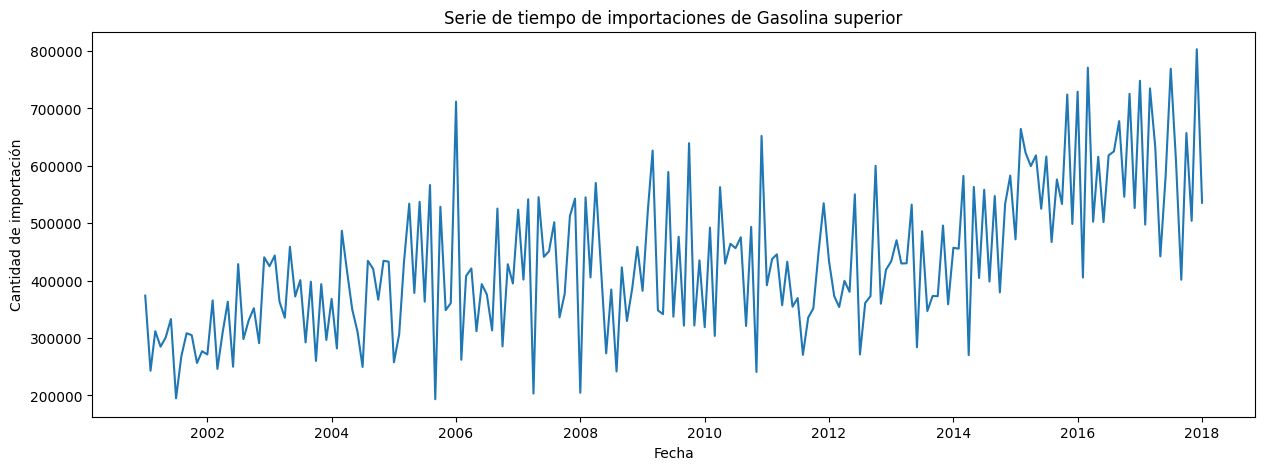

In [52]:
plt.plot(ts_imp_D)
plt.gca().set(title="Serie de tiempo de importaciones de Gasolina superior", xlabel="Fecha", ylabel="Cantidad de importación")
plt.show()

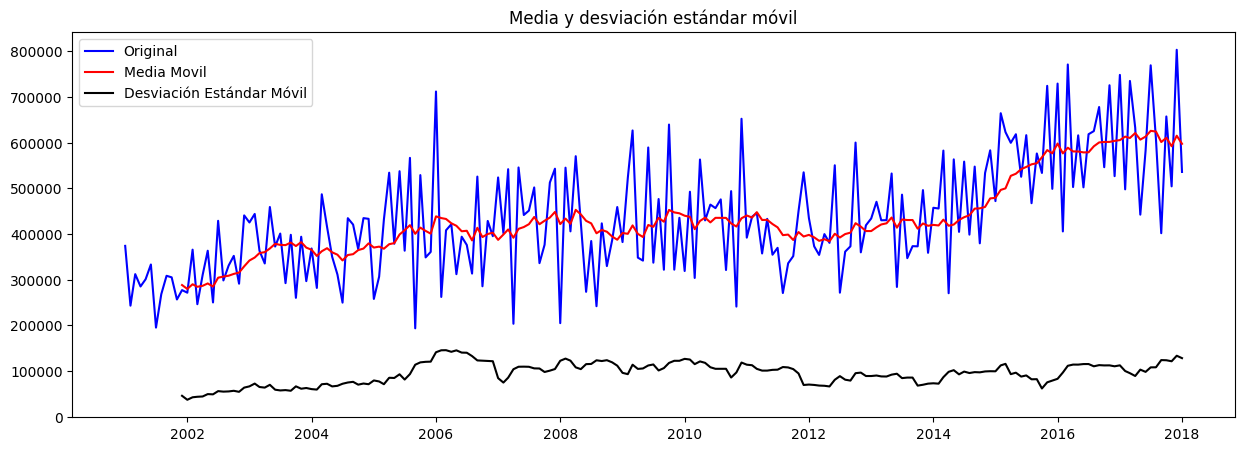

In [53]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_imp_D.rolling(window=12).mean()
deMovil = ts_imp_D.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_imp_D, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Media móvil (rojo): Muestra claramente la tendencia creciente de las importaciones.

Desviación estándar móvil (negro): Indica que la variabilidad también aumenta con el tiempo, lo que es típico en series no estacionarias.

Serie original (azul): Se aprecian fluctuaciones y picos, pero la tendencia general es al alza.

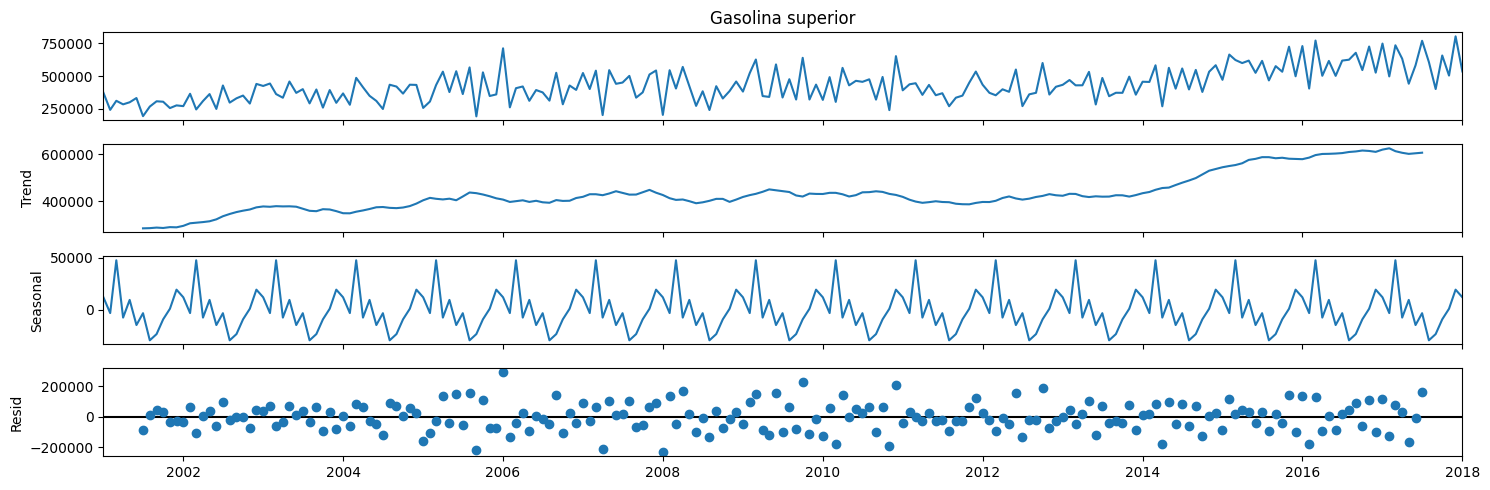

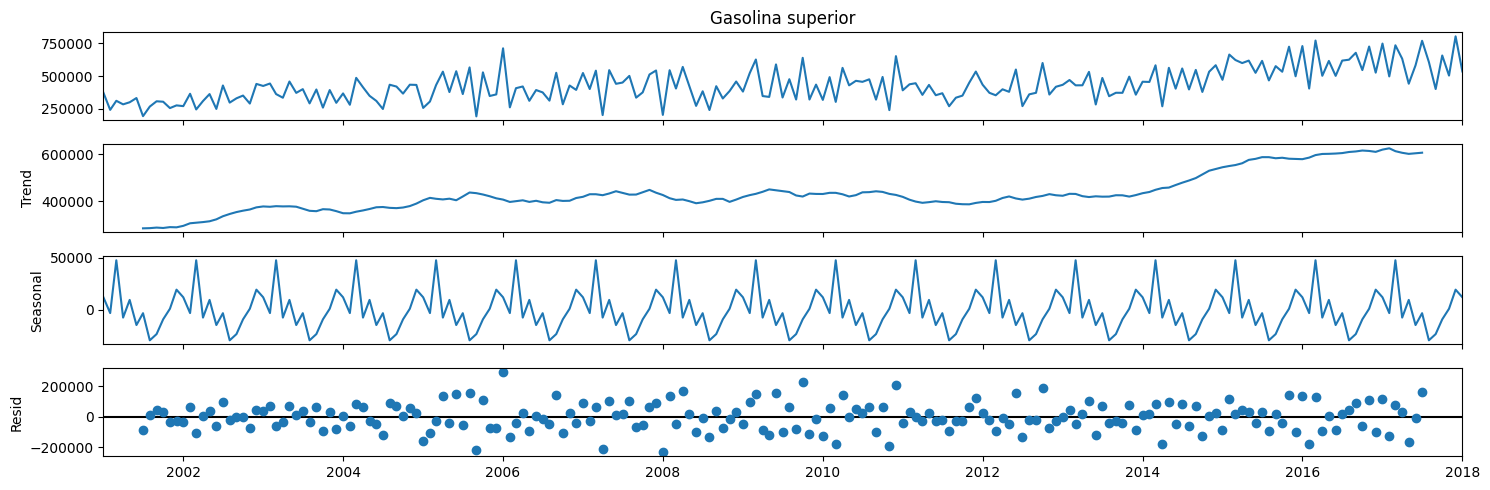

In [54]:
descomposicion = seasonal_decompose(ts_imp_D)
descomposicion.plot()

Tendencia: Se observa un crecimiento sostenido a lo largo de los años.

Estacionalidad: Hay un patrón estacional anual muy claro, con oscilaciones regulares cada año.

Residuales: Los residuos parecen estar centrados en cero, aunque con cierta variabilidad, lo que indica que la descomposición captura bien la tendencia y la estacionalidad.

## Estimar parámetros

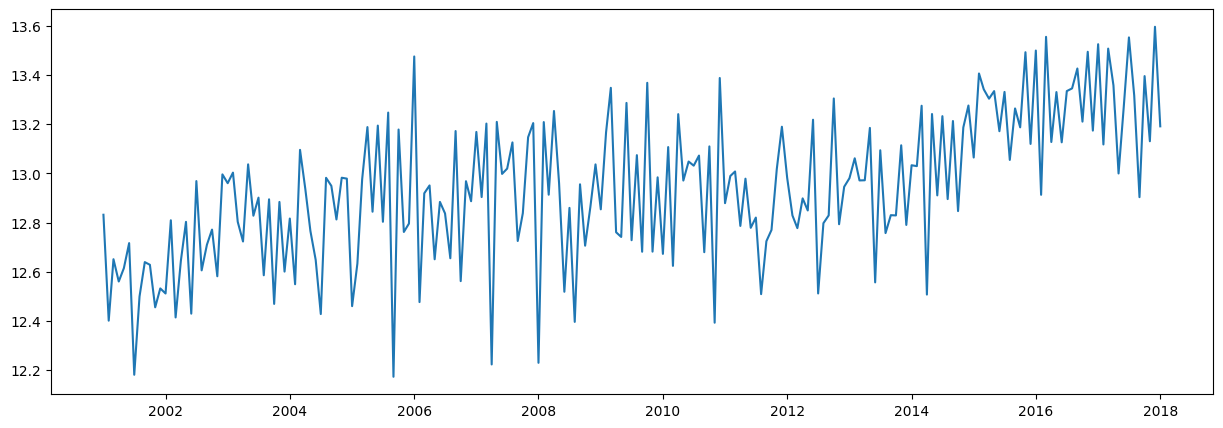

In [55]:
ts_imp_D_log = np.log(ts_imp_D)
plt.plot(ts_imp_D_log)

In [56]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_imp_D, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.489295
p-value                        0.538800
# de retardos usados           5.000000
# de observaciones usadas    199.000000
Critical Value (1%)           -3.463645
Critical Value (5%)           -2.876176
Critical Value (10%)          -2.574572
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [57]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = ts_imp_D.diff()
ts_imp_D_diff.dropna(inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -7.649031e+00
p-value                      1.809975e-11
# de retardos usados         9.000000e+00
# de observaciones usadas    1.940000e+02
Critical Value (1%)         -3.464515e+00
Critical Value (5%)         -2.876556e+00
Critical Value (10%)        -2.574775e+00
dtype: float64


El valor P es menor a 0.05, por lo que se puede rechazar la hipótesis nula y se puede decir que no hay raices unitarias.

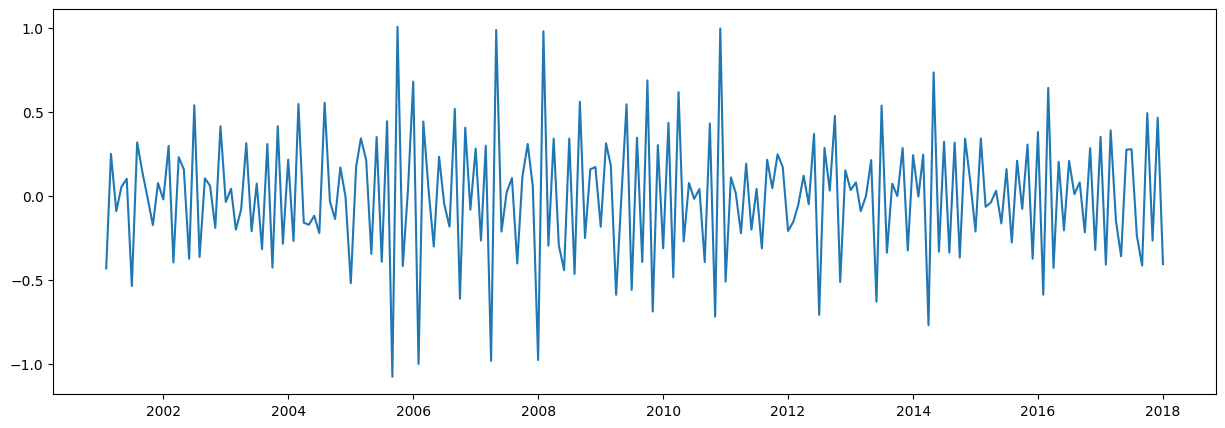

In [58]:
plt.plot(ts_imp_D_log.diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [60]:
ts_imp_D_log_diff = ts_imp_D_log.diff()
ts_imp_D_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_imp_D_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_imp_D_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.71311759,  0.35544436, -0.2282123 ,  0.12715234,
       -0.07607592])

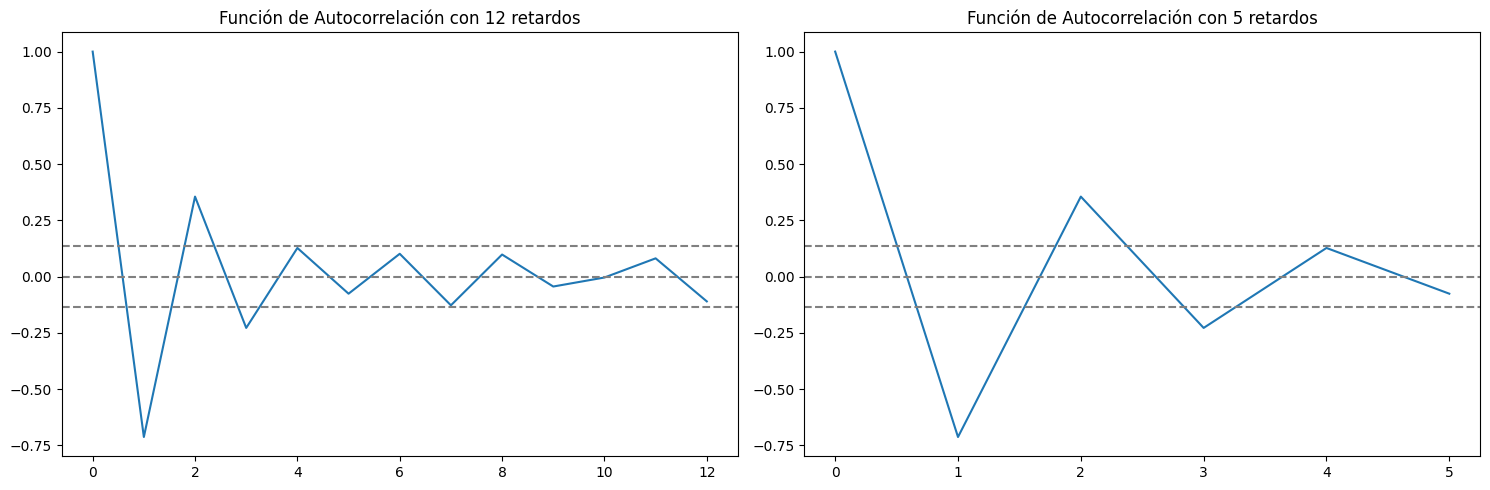

In [61]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_imp_D_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_imp_D_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

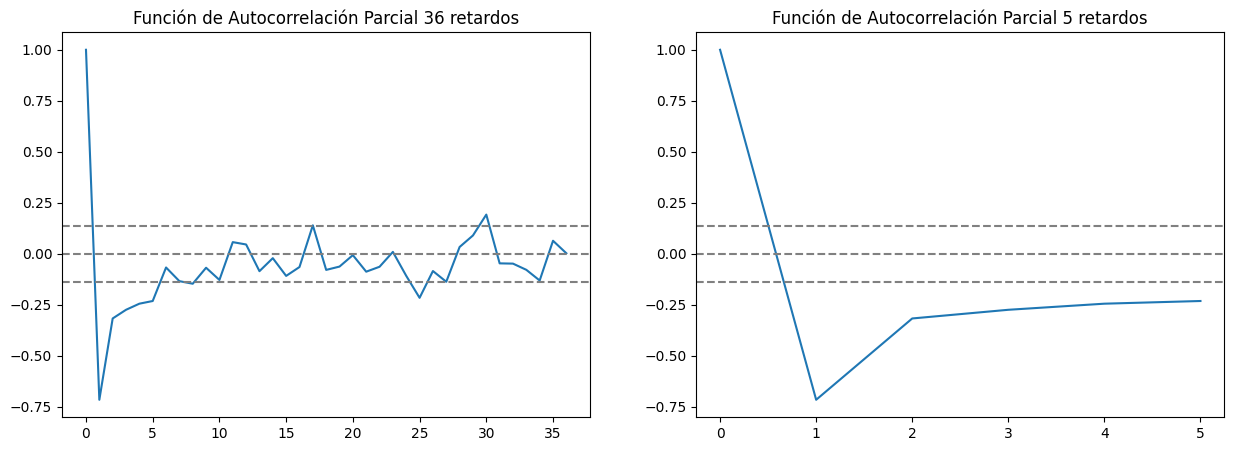

In [62]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_imp_D_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_imp_D_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Estacionalidad

Veamos ahora si hay estacionalidad en la serie. Hagamos un gráfico de la función de autocorrelación usando 36 resagos:

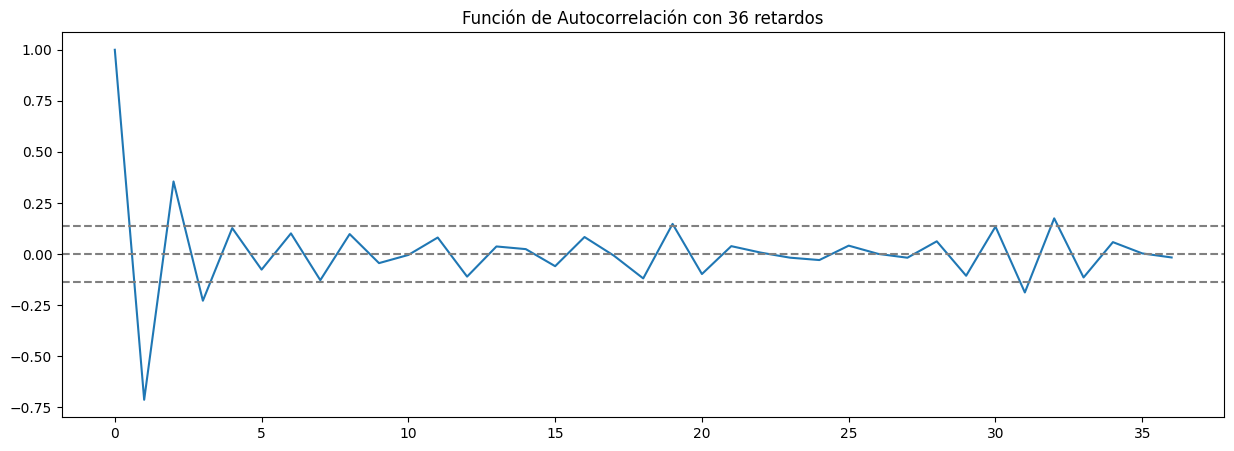

In [63]:
plt.plot(acf(ts_imp_D_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

La serie diferenciada no muestra autocorrelación significativa en los rezagos anuales, lo que sugiere que la estacionalidad fue eliminada o no es fuerte en la serie diferenciada.

In [64]:
ts_imp_D_log_D = ts_imp_D_log.diff(12)
ts_imp_D_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

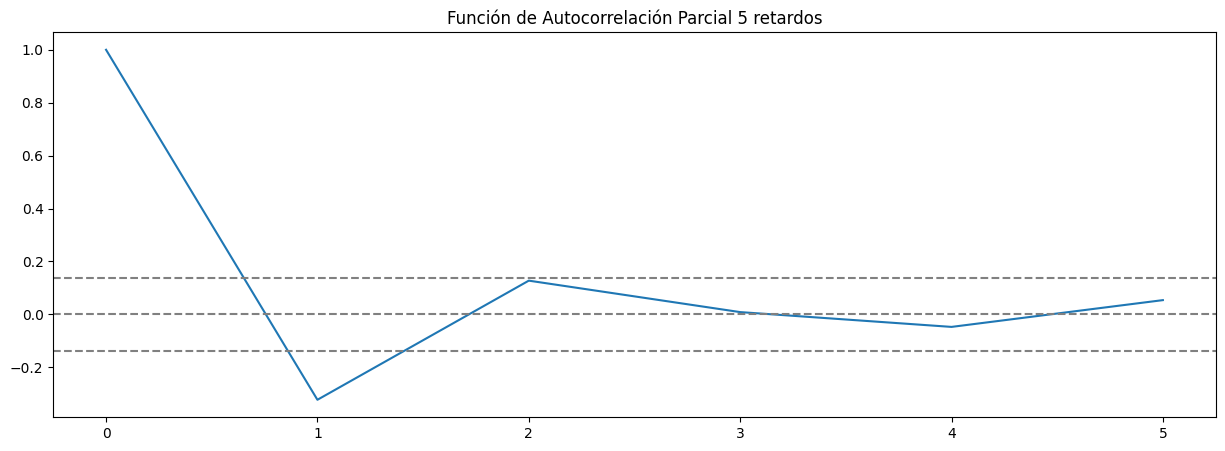

In [65]:
plt.plot(pacf(ts_imp_D_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_imp_D_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

In [66]:
modelo111 = SARIMAX(ts_imp_D_log, order=(1,1,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
print(resultado_m111.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4160      0.091     -4.552      0.000      -0.595      -0.237
ma.L1         -0.8813      0.049    -17.817      0.000      -0.978      -0.784
ar.S.L12      -0.7727      0.077     -9.982      0.000      -0.924      -0.621
ar.S.L24      -0.3878      0.068     -5.714      0.000      -0.521      -0.255
sigma2         0.0708      0.007      9.512      0.000       0.056       0.085


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


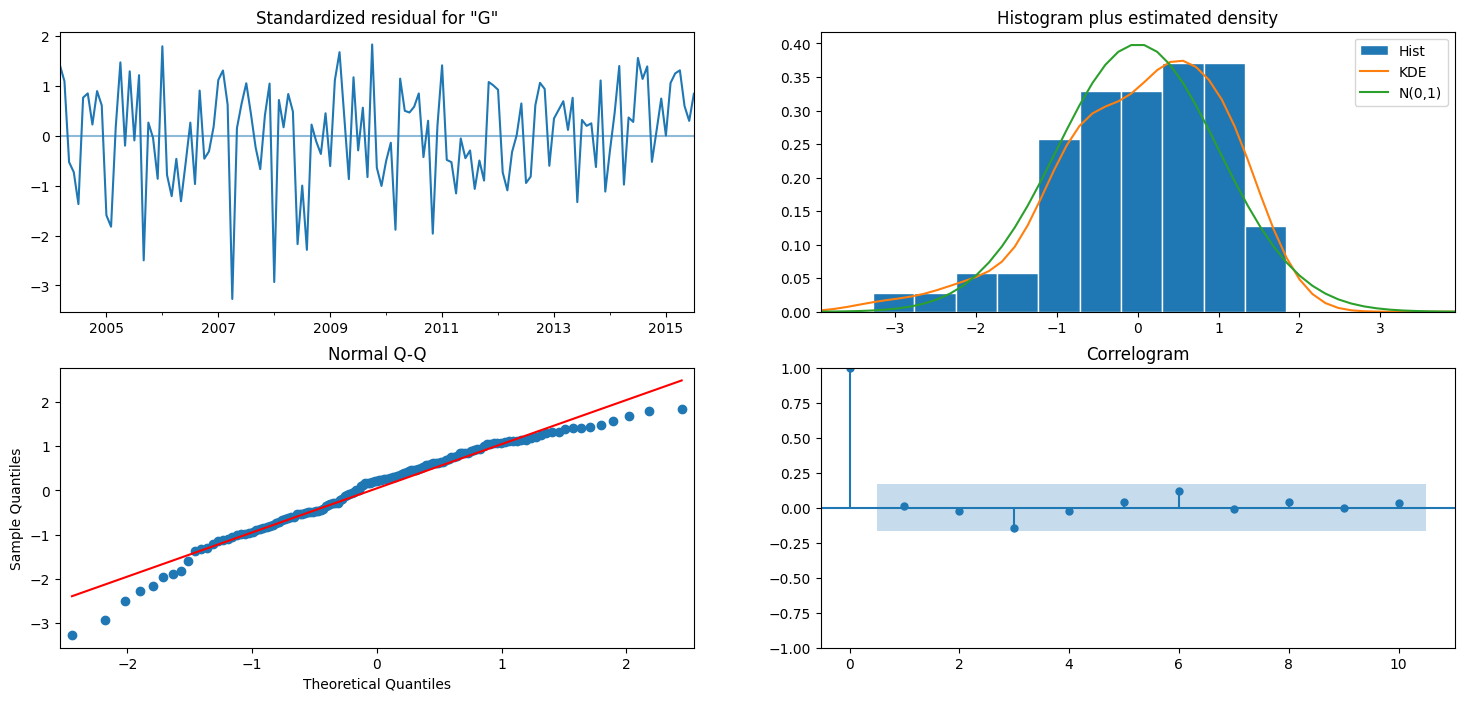

In [67]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

 Como se puede obserevar los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [68]:
modelo211 = SARIMAX(ts_imp_D_log, order=(2,1,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
print(resultado_m211.summary().tables[1])

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3913      0.108     -3.628      0.000      -0.603      -0.180
ar.L2          0.0384      0.097      0.396      0.692      -0.152       0.229
ma.L1         -0.8900      0.058    -15.438      0.000      -1.003      -0.777
ar.S.L12      -0.7686      0.077     -9.942      0.000      -0.920      -0.617
ar.S.L24      -0.3838      0.067     -5.692      0.000      -0.516      -0.252
sigma2         0.0702      0.007      9.590      0.000       0.056       0.085


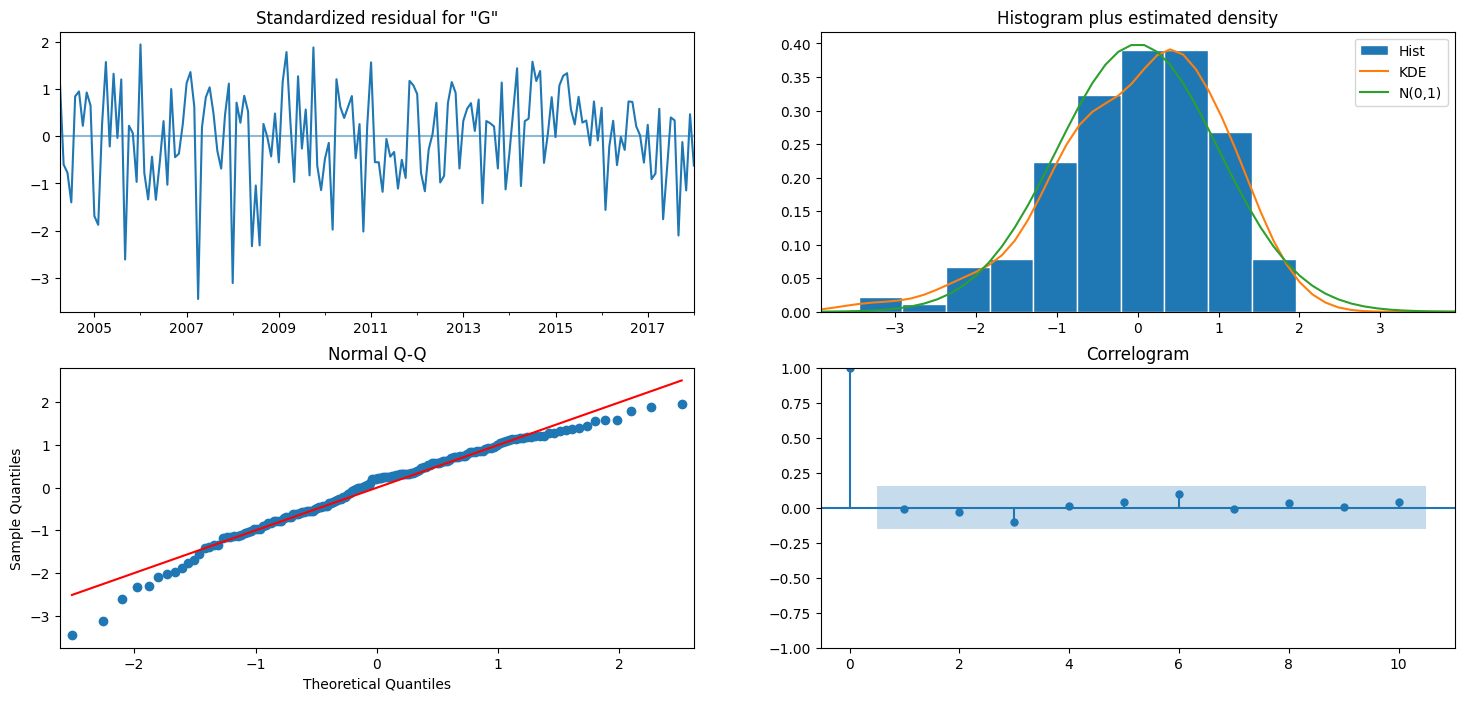

In [69]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

En este otro modelo tampoco existen autocorrelaciones significativas y parecen estar distribuidos de forma normal

In [70]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 42.98607479609294
Modelo 211= 42.958352545091685
Resultados de BIC (Bayesian information criterion)
Modelo 111= 58.57604385817672
Modelo 211= 61.63027927523095


El mejor modelo es p = 1, q=1, d=1

## Predicción con el mejor modelo

In [71]:
test_imp.index[0]

Timestamp('2021-09-01 00:00:00')

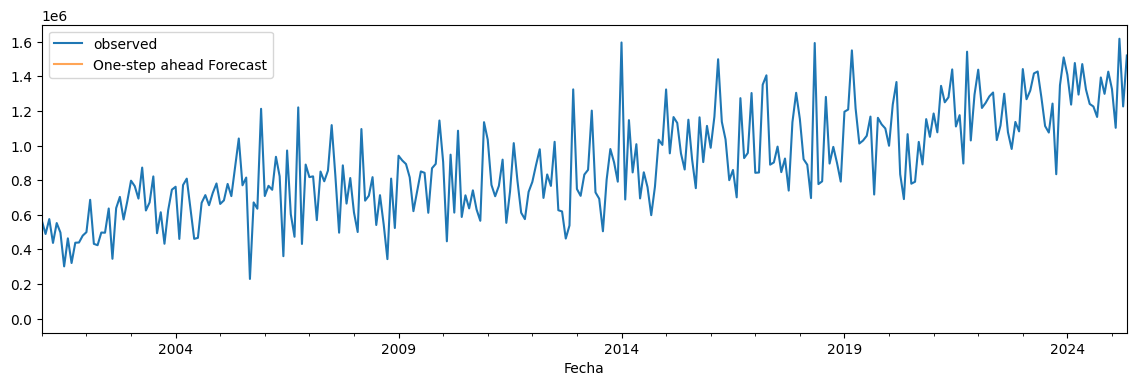

In [ ]:
pred = resultado_m111.get_prediction(start=test_imp.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = imp['Diesel'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.legend()
plt.show()

pred

In [112]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

train_size = int(len(imp) * 0.7)
val_size = int(len(imp) * 0.15)

train_imp = imp[0:train_size]
val_imp = imp[train_size:train_size + val_size]
test_imp = imp[train_size + val_size:len(imp)]

y_train = train_imp['Gasolina superior']
y_test = test_imp['Gasolina superior']

arima_model = ARIMA(y_train, order=(1, 1, 1))
arima_result = arima_model.fit()

y_pred_arima = arima_result.forecast(steps=len(y_test))

y_test_inv = y_test.values
y_pred_arima_inv = y_pred_arima 

rmse_arima = np.sqrt(mean_squared_error(y_test_inv, y_pred_arima_inv))
mae_arima = mean_absolute_error(y_test_inv, y_pred_arima_inv)

print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")


ARIMA - RMSE (prueba): 97676.85
ARIMA - MAE  (prueba): 70531.85


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Aquí empieza el laboratorio 2

In [114]:
tf.random.set_seed(123)
imp = pd.read_csv("IMPORTACIONES.csv", parse_dates=['Fecha'], index_col='Fecha')
print('\n Parsed Data:')
print(imp.head())

imp_anual = imp.resample('Y').sum()

super_anual = imp['Gasolina superior'].resample('Y').sum()

print(super_anual)



 Parsed Data:
            Aceites lubricantes  Asfalto      Bunker  Ceras  \
Fecha                                                         
2001-01-01                  0.0  27748.99  214581.84    0.0   
2001-02-01                  0.0   7503.57  294609.00    0.0   
2001-03-01                  0.0  26304.32  315263.80    0.0   
2001-04-01                  0.0   7885.89  205653.00    0.0   
2001-05-01                  0.0   8443.16  278371.30    0.0   

            Combustible turbo jet     Diesel  Diesel ultra bajo azufre  \
Fecha                                                                    
2001-01-01                    0.0  566101.99                       0.0   
2001-02-01                    0.0  489525.80                       0.0   
2001-03-01                    0.0  575559.68                       0.0   
2001-04-01                    0.0  437745.42                       0.0   
2001-05-01                    0.0  552609.13                       0.0   

            Gas licuado 

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_40336\3246172634.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  imp_anual = imp.resample('Y').sum()
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_40336\3246172634.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  super_anual = imp['Gasolina superior'].resample('Y').sum()


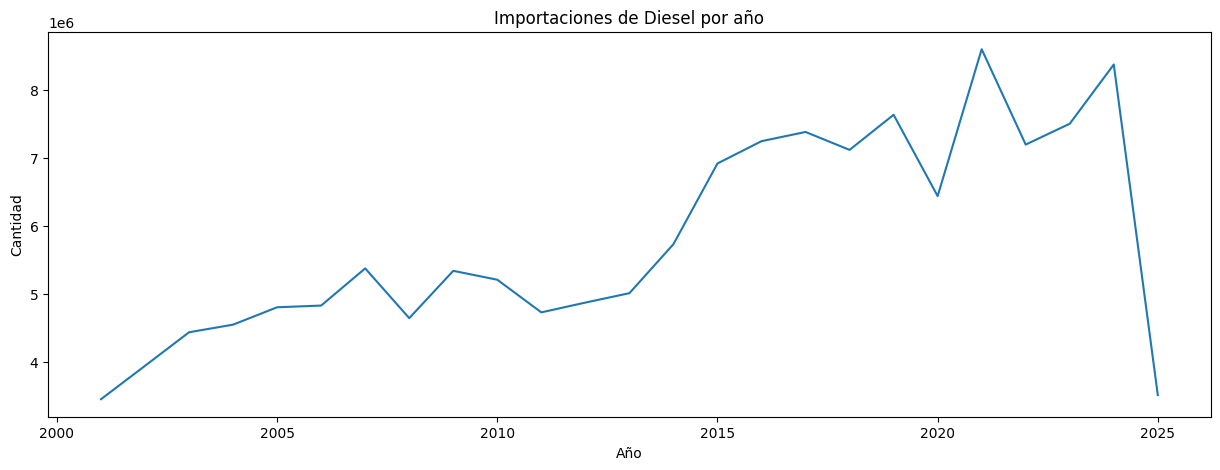

In [115]:
plt.plot(super_anual.index.year, super_anual.values)
plt.gca().set(title="Importaciones de Diesel por año", xlabel="Año", ylabel="Cantidad")
plt.show()

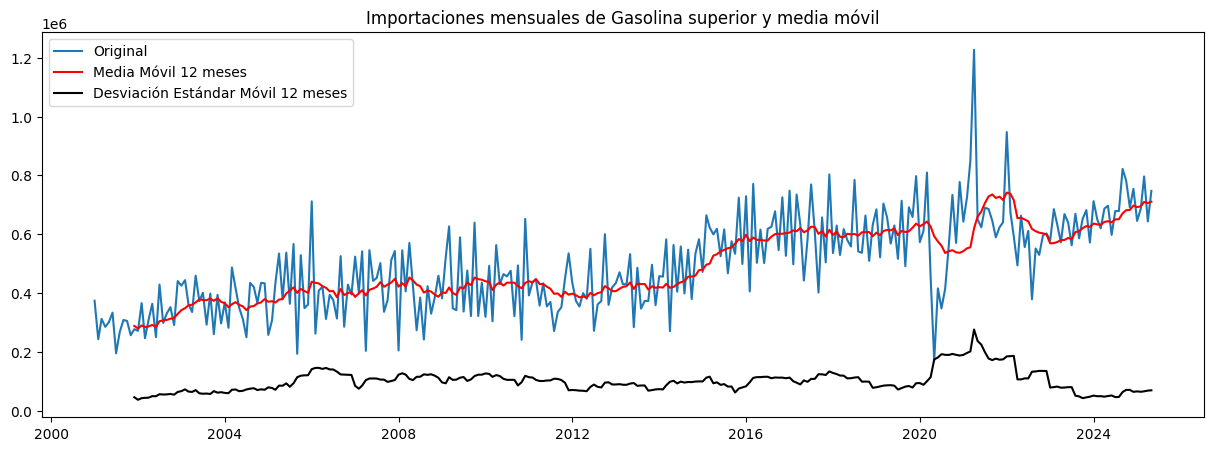

In [117]:
# Descomposición estacional
mediaMovil = imp['Gasolina superior'].rolling(window=12).mean()
deMovil = imp['Gasolina superior'].rolling(window=12).std()
plt.plot(imp['Gasolina superior'], label='Original')
plt.plot(mediaMovil, label='Media Móvil 12 meses', color='red')
plt.plot(deMovil, label='Desviación Estándar Móvil 12 meses', color='black')
plt.legend()
plt.title('Importaciones mensuales de Gasolina superior y media móvil')
plt.show()


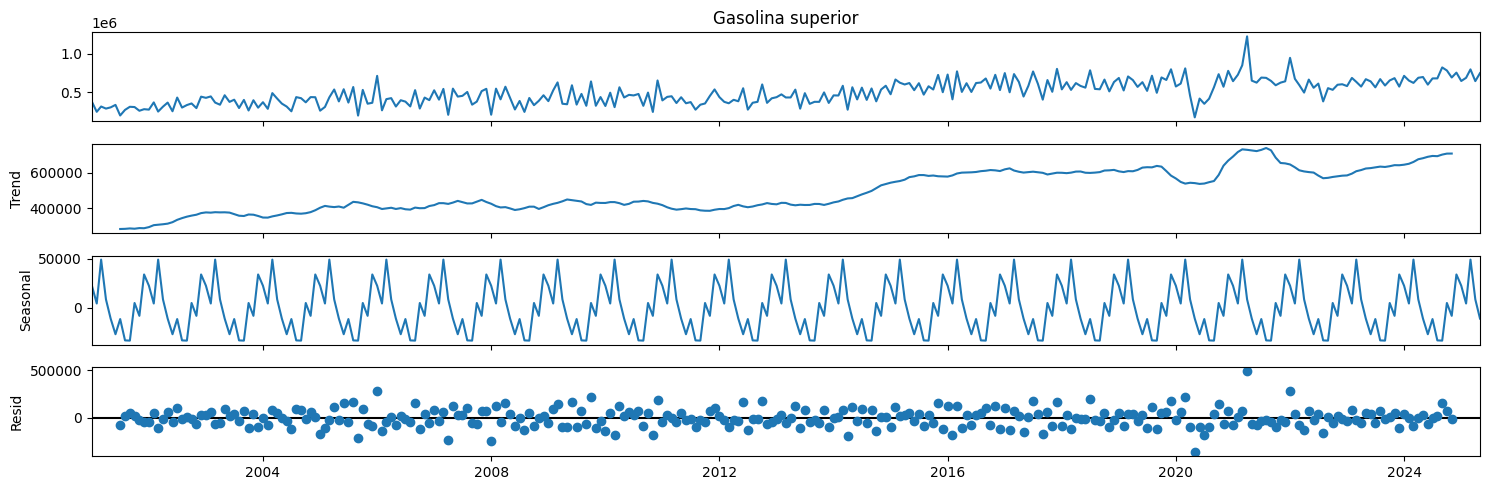

In [118]:
# Descomposición estacional sobre la serie mensual de Diesel
descomposicion = seasonal_decompose(imp['Gasolina superior'], model='additive', period=12)
descomposicion.plot()
plt.show()


Tendencia (Trend): Se observa una tendencia creciente a lo largo de los años, con algunos periodos de estabilidad y repuntes, lo que indica un aumento sostenido en las importaciones de Diesel.

Estacionalidad (Seasonal): Ahora sí se detecta un patrón estacional claro, con oscilaciones regulares cada año. Esto significa que hay meses en los que las importaciones tienden a subir o bajar de forma recurrente, probablemente por factores económicos, climáticos o de demanda.

Residuales (Resid): Los residuales muestran variabilidad alrededor de cero, lo que indica que el modelo de descomposición logra capturar bien la tendencia y la estacionalidad, aunque aún hay cierta variabilidad no explicada (ruido).

In [79]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_imp_D_diff = imp['Diesel'].diff()
ts_imp_D_diff.fillna(0,inplace=True)
dfTest = adfuller(ts_imp_D_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.223948e+00
p-value                      1.749540e-15
# de retardos usados         1.200000e+01
# de observaciones usadas    2.800000e+02
Critical Value (1%)         -3.453922e+00
Critical Value (5%)         -2.871918e+00
Critical Value (10%)        -2.572300e+00
dtype: float64


Con una diferenciacion la serie es estacionaria en media.

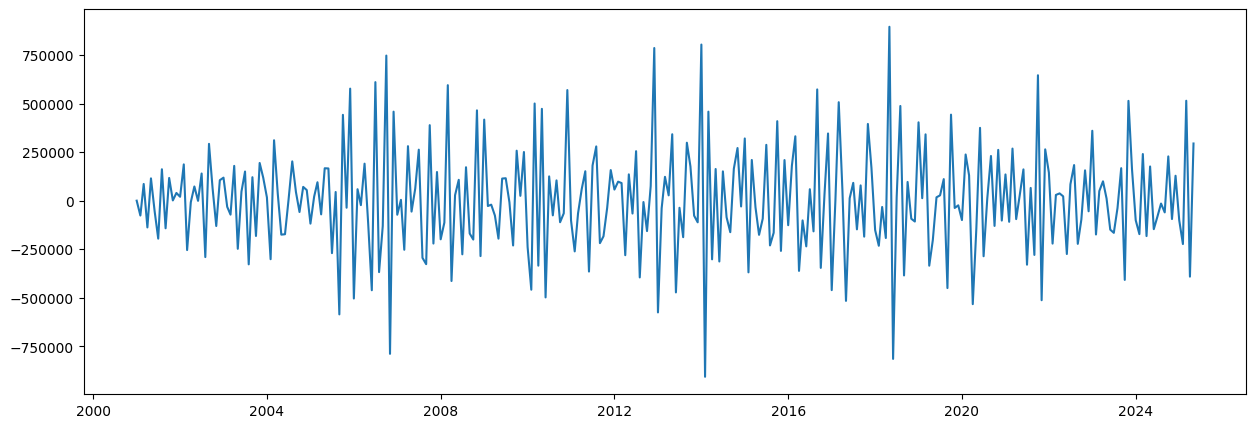

In [119]:
plt.plot(ts_imp_D_diff)

In [120]:
scaler = StandardScaler()
ts_imp_D_scaled = scaler.fit_transform(ts_imp_D_diff.values.reshape(-1, 1))
ts_imp_D_scaled[1:7]


array([[-0.29281567],
       [ 0.30360661],
       [-0.51742506],
       [ 0.40934885],
       [-0.21277562],
       [-0.72902441]])

In [122]:
val_prueba = round(0.15*len(ts_imp_D_scaled))
val_prueba

44

In [123]:
entrenamiento = round(0.7*len(ts_imp_D_scaled))
val_prueba = round(0.15*len(ts_imp_D_scaled))
test = ts_imp_D_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_imp_D_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_imp_D_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

45

In [124]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [125]:
print(train[0:7])
print(x_train[0:7])
print(y_train[0:7])


[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]
 [-0.21277562]]
[[ 0.        ]
 [-0.01194902]
 [-0.29281567]
 [ 0.30360661]
 [-0.51742506]
 [ 0.40934885]
 [-0.21277562]]
[-0.01194902 -0.29281567  0.30360661 -0.51742506  0.40934885 -0.21277562
 -0.72902441]


Creando el modelo

In [126]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

44

In [127]:
x_train

array([[[ 0.        ]],

       [[-0.01194902]],

       [[-0.29281567]],

       [[ 0.30360661]],

       [[-0.51742506]],

       [[ 0.40934885]],

       [[-0.21277562]],

       [[-0.72902441]],

       [[ 0.5815355 ]],

       [[-0.53353381]],

       [[ 0.41731863]],

       [[-0.00734298]],

       [[ 0.13380199]],

       [[ 0.06162003]],

       [[ 0.67349988]],

       [[-0.94498534]],

       [[-0.04081869]],

       [[ 0.25622009]],

       [[-0.01545192]],

       [[ 0.50118159]],

       [[-1.07745723]],

       [[ 1.06164811]],

       [[ 0.2257857 ]],

       [[-0.49045219]],

       [[ 0.37485838]],

       [[ 0.42303355]],

       [[-0.12723448]],

       [[-0.27592234]],

       [[ 0.64517809]],

       [[-0.921246  ]],

       [[ 0.15931096]],

       [[ 0.53870509]],

       [[-1.21472335]],

       [[ 0.43121939]],

       [[-0.67886147]],

       [[ 0.6999898 ]],

       [[ 0.42208124]],

       [[ 0.04989229]],

       [[-1.1175651 ]],

       [[ 1.12940181]],



### Creamos el modelo.   
#### Tensor Flow
Vamos a utilizar solo una capa LSTM 

In [128]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

#Tensor Flow 2
#modelo1 = Sequential()
#modelo1.add(LSTM(lote,batch_input_shape=(lote,paso,caracteristicas),stateful=True))
#modelo1.add(Dense(1))
#modelo1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [129]:
#early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [130]:
modelo1

<Functional name=functional_1, built=True>

In [131]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6023 - root_mean_squared_error: 0.7493 - val_loss: 0.9501 - val_root_mean_squared_error: 0.9747
Epoch 2/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5796 - root_mean_squared_error: 0.7383 - val_loss: 0.9494 - val_root_mean_squared_error: 0.9744
Epoch 3/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5778 - root_mean_squared_error: 0.7375 - val_loss: 0.9464 - val_root_mean_squared_error: 0.9728
Epoch 4/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5755 - root_mean_squared_error: 0.7359 - val_loss: 0.9441 - val_root_mean_squared_error: 0.9717
Epoch 5/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5737 - root_mean_squared_error: 0.7347 - val_loss: 0.9427 - val_root_mean_squared_error: 0.9709
Epoch 6/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5731 - root_mean_squared_error: 0.7344 - val_loss: 0.9418 - val_root_mean_squared_error: 0.9705
Epoch 7/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

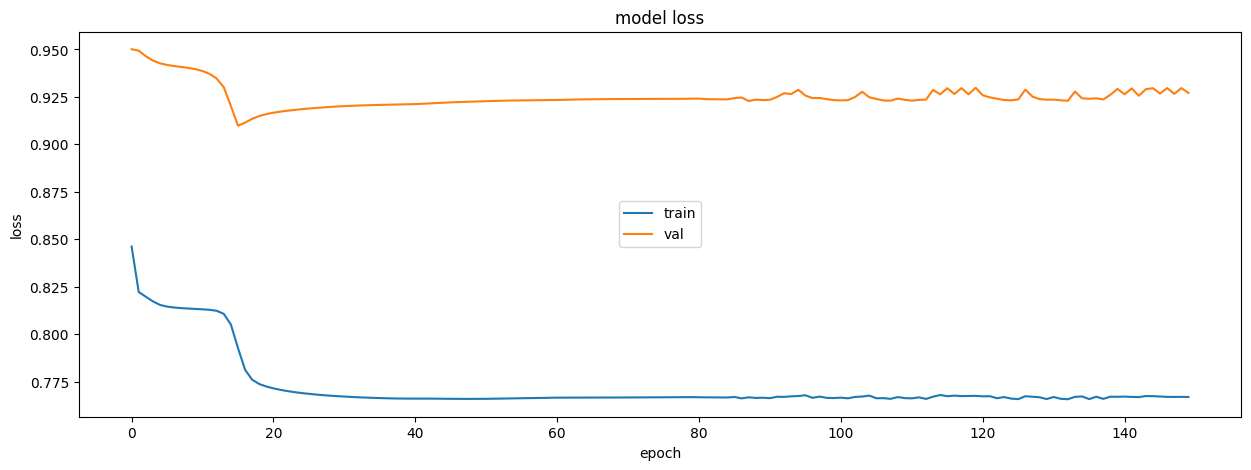

In [132]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

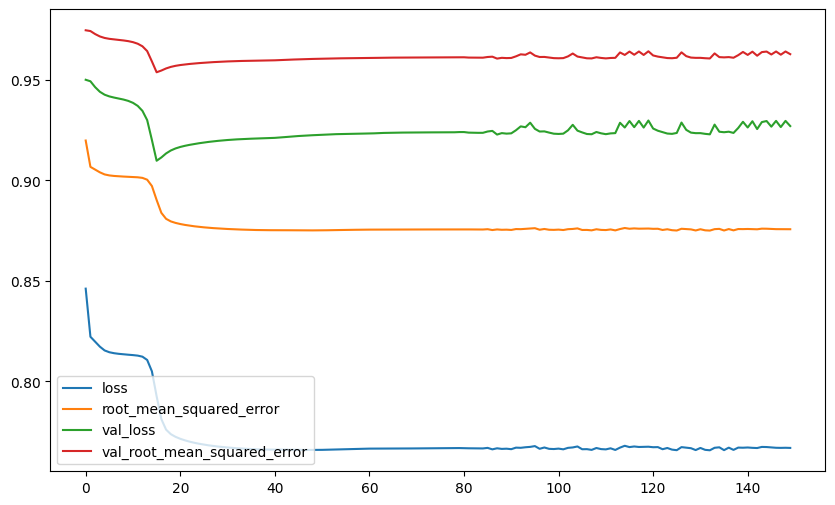

In [133]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [134]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6346 - root_mean_squared_error: 0.7895  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.9610 - root_mean_squared_error: 0.9800
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6118 - root_mean_squared_error: 0.7821


[0.597447395324707, 0.7729471921920776]

In [136]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Gasolina superior'].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = imp['Gasolina superior'].values , n=entrenamiento+val_prueba)


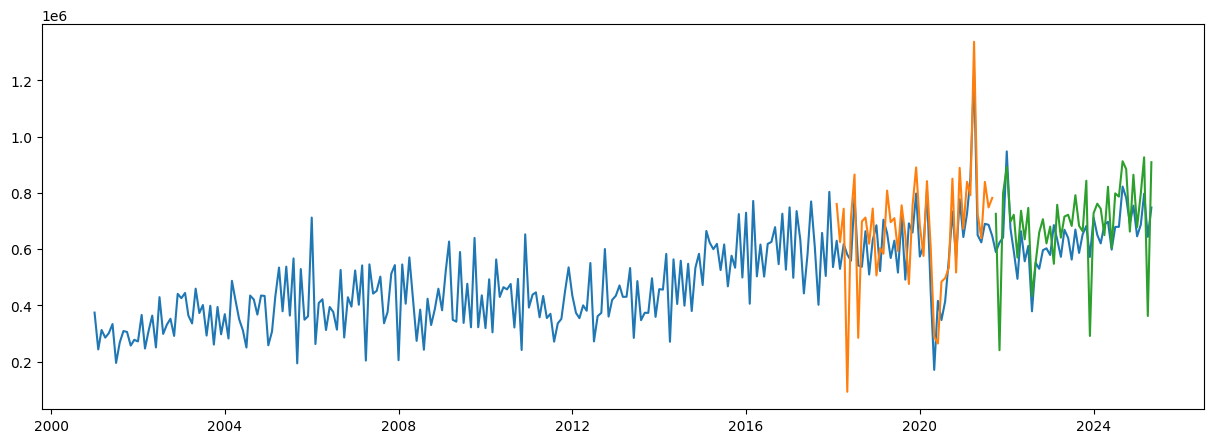

In [138]:
df_val = pd.DataFrame(prediccion_val,index=imp['Gasolina superior'][(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=imp['Gasolina superior'][entrenamiento+len(df_val):len(imp['Gasolina superior'])].index)


plt.plot(imp['Gasolina superior'])
plt.plot(df_val)
plt.plot(df_test)

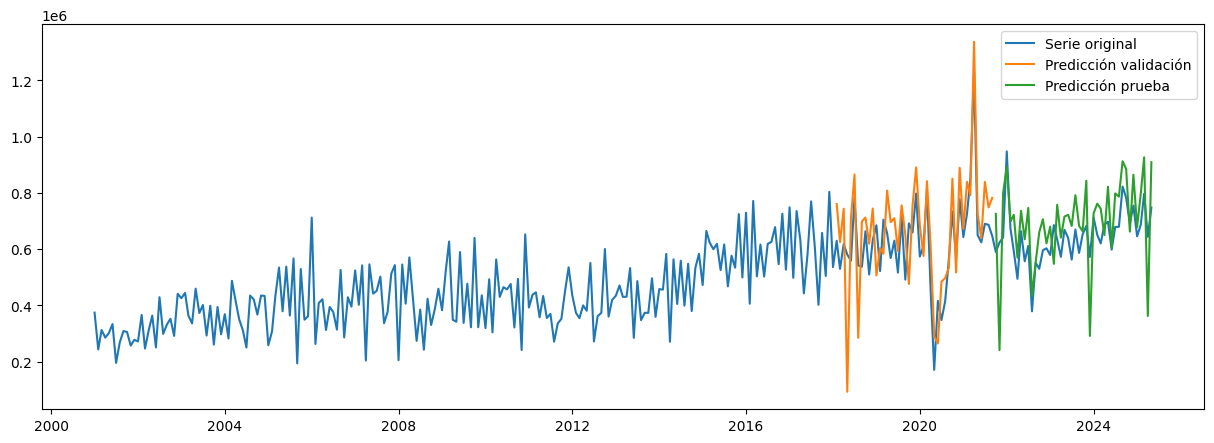

In [140]:
plt.plot(imp['Gasolina superior'], label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.show()

## Pytorch

Se define la clase que hereda de los modelos nn de pytorch para este modelo en específico

In [141]:
class LSTMMiModelo(nn.Module):
    def __init__(self,input_size=1,hidden_size=20, num_layers = 1,output_size = 1 ):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  
        self.hidden_size = hidden_size

    def forward(self,x):
        # x shape: (batch, seq_len, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [142]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 12 #Por el ciclo estacional, una ventana de un año

# Después, rehace tus ventanas:
x_train, y_train = create_sequences(train, SEQ_LENGTH)
x_val, y_val     = create_sequences(validation, SEQ_LENGTH)
x_test, y_test   = create_sequences(test, SEQ_LENGTH)

In [143]:
model = LSTMMiModelo()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Preparación de los datos
x_train_tensor = torch.from_numpy(x_train).float()        
y_train_tensor = torch.from_numpy(y_train).float()
x_val_tensor = torch.from_numpy(x_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Entrenamiento
En pytorch hay que hacer el entrenamiento "a mano" para tener el control del todo

In [144]:

train_losses = []
val_losses = []
model.train()
running_train_loss = 0.0
for epoch in range(epocas):
    running_train_loss = 0.0  # Acumula la pérdida de la época
    for xb, yb in train_loader:  # Recorre cada batch
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * xb.size(0)
    
    # Calcula y muestra la pérdida promedio en el entrenamiento de la época
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss) 

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            running_val_loss += loss.item() * xb.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}, Loss promedio: {epoch_train_loss:.5f}")

Epoch 1, Loss promedio: 1.04052
Epoch 10, Loss promedio: 0.62103
Epoch 20, Loss promedio: 0.60108
Epoch 30, Loss promedio: 0.63411
Epoch 40, Loss promedio: 0.65015
Epoch 50, Loss promedio: 0.55548
Epoch 60, Loss promedio: 0.53285
Epoch 70, Loss promedio: 0.52984
Epoch 80, Loss promedio: 0.43391
Epoch 90, Loss promedio: 0.46215
Epoch 100, Loss promedio: 0.40203
Epoch 110, Loss promedio: 0.31898
Epoch 120, Loss promedio: 0.24445
Epoch 130, Loss promedio: 0.17028
Epoch 140, Loss promedio: 0.11921
Epoch 150, Loss promedio: 0.03975


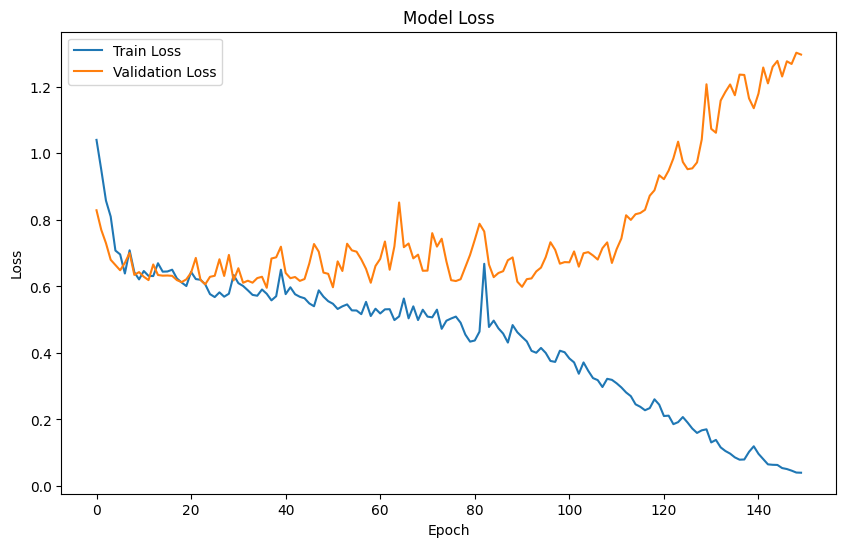

In [145]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [146]:
x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
model.eval()
with torch.no_grad():
    # Forma: (num_ejemplos, ventana, 1)
    y_pred_test = model(x_test_tensor)
    y_pred_test = y_pred_test.numpy()  # Convierte a numpy para graficar

In [147]:
#Desnormalizar
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

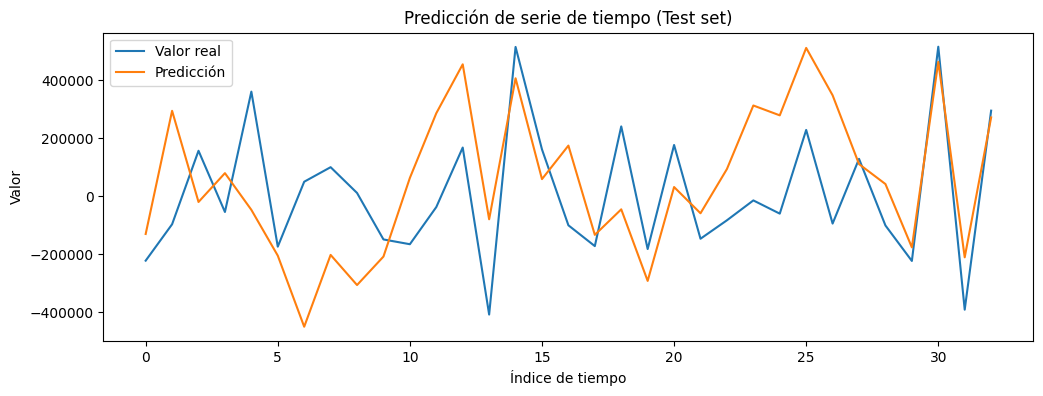

In [148]:
# Graficar
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred_test_inv, label='Predicción')
plt.title('Predicción de serie de tiempo (Test set)')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [149]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))
mae_lstm = mean_absolute_error(y_test_inv, y_pred_test_inv)

print(f"LSTM - RMSE (test): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (test): {mae_lstm:.2f}")

LSTM - RMSE (test): 244752.80
LSTM - MAE  (test): 204790.07


### Comparativa entre modelos

In [150]:
# Comparación de métricas entre ARIMA y LSTM

print(f"ARIMA - RMSE (prueba): {rmse_arima:.2f}")
print(f"ARIMA - MAE  (prueba): {mae_arima:.2f}")
print(f"LSTM - RMSE (prueba): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (prueba): {mae_lstm:.2f}")

print("\nComparación de modelos:")
if rmse_arima < rmse_lstm:
    print("ARIMA tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")
else:
    print("LSTM tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.")

if mae_arima < mae_lstm:
    print("ARIMA tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")
else:
    print("LSTM tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.")

ARIMA - RMSE (prueba): 97676.85
ARIMA - MAE  (prueba): 70531.85
LSTM - RMSE (prueba): 244752.80
LSTM - MAE  (prueba): 204790.07

Comparación de modelos:
ARIMA tiene un RMSE más bajo, lo que indica mejor rendimiento en términos de errores cuadrados.
ARIMA tiene un MAE más bajo, lo que indica mejor rendimiento en términos de errores absolutos.
